# Fitting of tunneling spectroscopy measurments
In this notebook, some pyusadel routines are used to fit NS tunneling spectroscopy data.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

from pyusadel import (
    DifferentialOperators,
    UsadelProblem,
    gen_assemble_fns,
    solve_usadel,
    trivial_diffops,
)

In [2]:
def fit(
    e_ax_exp, dos_exp, Delta_0: float = 0.250, T: float = 0.0, verbose: bool = False
):
    """Fit the experimental data.

    Parameters:
    -------
    e_ax_exp : np.ndarray
        Energy axis of the experimental data.
    dos_exp : np.ndarray
        Spectroscopy data.
    Delta_0 : float
        Initial guess for the gap (in units of energy).
    T : float
        Temperature (in units of energy).
    """

    # TODO : temperature broadening is not included

    # N_0, Delta, h, tau_sf_inv, Gamma
    p0 = ((dos_exp[0] + dos_exp[-1]) / 2, Delta_0, 0.00, 0.00, 1e-3)

    do = trivial_diffops()

    theta = np.ones((e_ax_exp.shape[0], 1), dtype=complex)
    M_x = np.zeros((e_ax_exp.shape[0], 1), dtype=complex)

    def wrapper(omega_ax_exp, *params):
        if verbose:
            print(
                f"""N_0 = {params[0]:3.2f}, Delta = {params[1]:3.2f}, h = {params[2]:3.2f}, tau_sf_inv = {params[3]:3.2f}, Gamma = {params[4]:3.2e}"""
            )
        N_0, Delta, h, tau_sf_inv, Gamma = params

        assemble_fns = gen_assemble_fns(
            D=0,
            diff_ops=do,
            h_x=h,
            h_y=0,
            h_z=0,
            tau_so_inv=0,
            tau_sf_inv=tau_sf_inv,
            Gamma=Gamma,
        )

        solve_usadel(
            assemble_fns=assemble_fns,
            h_x=h,
            h_y=0,
            h_z=0,
            theta=theta,
            M_x=M_x,
            M_y=0,
            M_z=0,
            Delta=Delta,
            omega_ax=-1j * omega_ax_exp,
            gamma=1.0,
            tol=1e-6,
            max_iter=1000,
            print_exit_status=False,
            use_dense=True,
        )

        M_0 = np.sqrt(1 + M_x**2)

        return N_0 * np.real(M_0 * np.cos(theta))[:, 0]

    return curve_fit(
        f=wrapper,
        xdata=e_ax_exp,
        ydata=dos_exp,
        p0=p0,
        # sigma=None,
        # absolute_sigma=False,
        check_finite=True,
        bounds=([0.0, 0.0, 0.0, 0.0, 1e-4], [1.0, 0.5, 0.4, 0.1, 1e-1]),
        # method=None,
        # jac=None,
        # full_output=True,
    )

In [3]:
data = np.loadtxt("MDC004_cuts/MDC004_12_RunID_15_cut-16mT.dat")
e_ax_exp = data[:, 0]
dos_exp = data[:, 1]

Text(0, 0.5, '$I$ (?)')

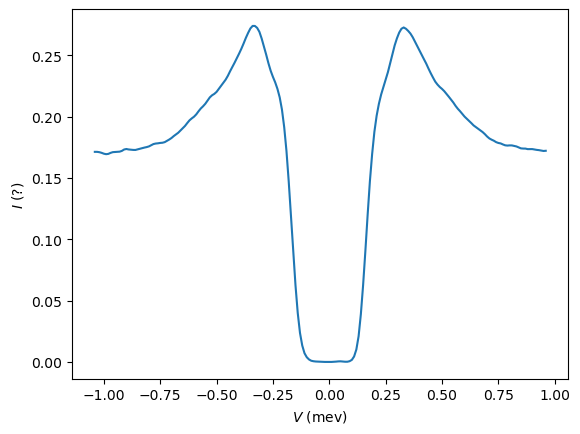

In [4]:
fig, ax = plt.subplots()
ax.plot(e_ax_exp, dos_exp)
ax.set_xlabel(r"$V$ (mev)")
ax.set_ylabel(r"$I$ (?)")

In [5]:
popt, pcov = fit(e_ax_exp, dos_exp, Delta_0=0.250, verbose=True)

N_0 = 0.17, Delta = 0.25, h = 0.00, tau_sf_inv = 0.00, Gamma = 1.00e-03
N_0 = 0.17, Delta = 0.25, h = 0.00, tau_sf_inv = 0.00, Gamma = 1.00e-03
N_0 = 0.17, Delta = 0.25, h = 0.00, tau_sf_inv = 0.00, Gamma = 1.00e-03
N_0 = 0.17, Delta = 0.25, h = 0.00, tau_sf_inv = 0.00, Gamma = 1.00e-03
N_0 = 0.17, Delta = 0.25, h = 0.00, tau_sf_inv = 0.00, Gamma = 1.00e-03
N_0 = 0.17, Delta = 0.25, h = 0.00, tau_sf_inv = 0.00, Gamma = 1.00e-03
N_0 = 0.17, Delta = 0.25, h = 0.00, tau_sf_inv = 0.02, Gamma = 2.36e-03
N_0 = 0.17, Delta = 0.25, h = 0.00, tau_sf_inv = 0.02, Gamma = 2.36e-03
N_0 = 0.17, Delta = 0.25, h = 0.00, tau_sf_inv = 0.02, Gamma = 2.36e-03
N_0 = 0.17, Delta = 0.25, h = 0.00, tau_sf_inv = 0.02, Gamma = 2.36e-03
N_0 = 0.17, Delta = 0.25, h = 0.00, tau_sf_inv = 0.02, Gamma = 2.36e-03
N_0 = 0.17, Delta = 0.25, h = 0.00, tau_sf_inv = 0.02, Gamma = 2.36e-03
N_0 = 0.18, Delta = 0.26, h = 0.01, tau_sf_inv = 0.03, Gamma = 1.11e-02
N_0 = 0.18, Delta = 0.26, h = 0.01, tau_sf_inv = 0.03, Gamma = 1

In [6]:
N_0, Delta, h, tau_sf_inv, Gamma = popt

up = UsadelProblem(
    Nsites=1,
    diff_ops=trivial_diffops(),
    h_x=np.array([0.0]) + h,
    h_y=np.array([0.0]),
    h_z=np.array([0.0]),
    tau_sf_inv=np.array([0.0]) + tau_sf_inv,
    tau_so_inv=np.array([0.0]) + 0.0,
    D=0,
    T=0.2,
    Gamma=Gamma,
)

up.Delta = np.array([Delta])

up.set_real_omega_ax(-1, 1, 201)
up.solve_spectral()

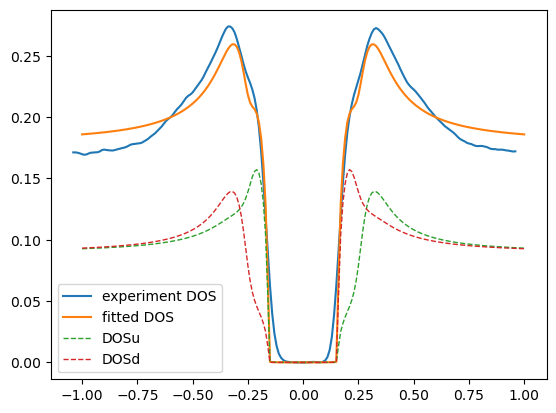

In [7]:
plt.plot(e_ax_exp, dos_exp, label="experiment DOS")
plt.plot(up.get_omega_ax_r(), N_0 * up.get_dos(), label="fitted DOS")
plt.plot(
    up.get_omega_ax_r(),
    N_0 * up.get_spin_resolved_dos("x")[0],
    "--",
    linewidth=1,
    label="DOSu",
)
plt.plot(
    up.get_omega_ax_r(),
    N_0 * up.get_spin_resolved_dos("x")[1],
    "--",
    linewidth=1,
    label="DOSd",
)
plt.legend()

## Thermal broadening (wip)

In [30]:
def thermal_broadening(e_ax, x, T):
    """
    Broaden the data in x by convoluting it to df/de.
    """
    if T<5e-3:
        raise Exception("Temperature too low for broadening.")
    else:
        def df_de(eps, T):
            """
            Derivative of Fermi-Dirac distribution.
            """
            return 1 / (2 * T * (1 + np.cosh(eps / T)))

    de = (e_ax[1] - e_ax[0]).astype(np.float128)
    e_ax = e_ax.astype(np.float128)
    out = np.zeros_like(e_ax, dtype=np.float128)

    for i in range(e_ax.shape[0]):
        for j in range(e_ax.shape[0]):
            out[i] += x[j] * df_de(e_ax[i] - e_ax[j], T) * de

    return out

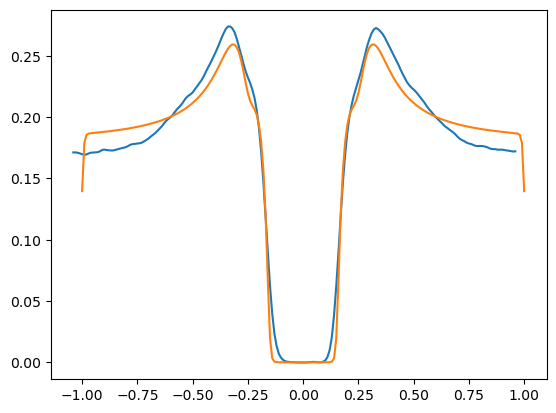

In [42]:
tb = thermal_broadening(e_ax_exp,  N_0 * up.get_dos(), T=5e-3)
plt.plot(e_ax_exp, dos_exp)
plt.plot(up.get_omega_ax_r(), tb)

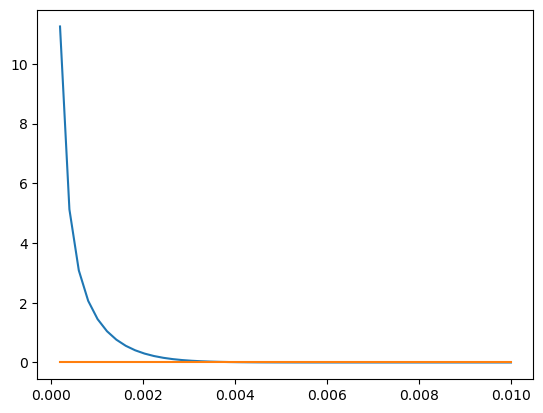

In [33]:
plt.plot(T_ax, np.abs(norm-1))
plt.plot(T_ax, norm*0)

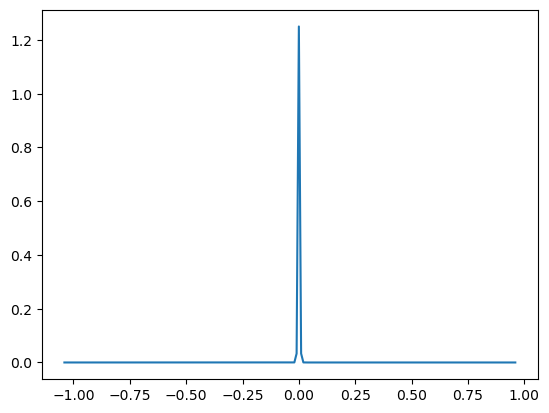

In [31]:
T = 2e-3
plt.plot(e_ax_exp, df_de(e_ax_exp, T) * (e_ax_exp[1]-e_ax_exp[0]))

# # plt.plot(e_ax_exp, f(e_ax_exp - 0.15, T))
# # plt.plot(e_ax_exp, f(e_ax_exp - 0.15, T) - f(e_ax_exp, 1e-6))

In [32]:
T_ax = np.linspace(0, 1, 50) * 1e-2
norm = np.zeros_like(T_ax)

for i in range(50):
    norm[i] = np.sum(df_de(e_ax_exp, T_ax[i]) * (e_ax_exp[1]-e_ax_exp[0]))

/tmp/ipykernel_27469/1465143184.py:5: RuntimeWarning: divide by zero encountered in true_divide
  return 1 / (2 * T * (1 + np.cosh(eps / T)))
/tmp/ipykernel_27469/1465143184.py:5: RuntimeWarning: invalid value encountered in multiply
  return 1 / (2 * T * (1 + np.cosh(eps / T)))
/tmp/ipykernel_27469/1465143184.py:5: RuntimeWarning: overflow encountered in cosh
  return 1 / (2 * T * (1 + np.cosh(eps / T)))
